In [1]:
import pandas as pd
import numpy as np
from numpy import sin, cos, arccos, pi, round
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.express as px
from IPython.display import clear_output
from tqdm import tqdm
import warnings

import lightgbm as lgb

from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, precision_recall_curve, roc_curve, auc 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import Lasso, LinearRegression, HuberRegressor

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [2]:
def classifier_performance(Y, Y_hat, Y_score):
    fpr, tpr, thresholds_roc = roc_curve(Y, Y_score)
    roc_auc = auc(fpr, tpr)
    plt.rcParams.update({'font.size': 10})

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate', fontsize = 10)
    plt.ylabel('True Positive Rate', fontsize = 10)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize = 10)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.grid(True)
    plt.show()
    
    
    precision = precision_score(Y, Y_hat)
    recall = recall_score(Y, Y_hat)
    f1 = f1_score(Y, Y_hat)
    print(f"Precision: {round(precision, 4)}, Recall: {round(recall, 4)}, F1 score: {round(f1, 4)}, Accuracy: {round(np.sum(Y == Y_hat) / Y.shape[0], 4)}")

In [3]:
def standardizer(X_train, X_test):
    """
    features need to be standardize:
    Total Land Transfer Area, Total Building Transfer Area, Current Building Layout-Rooms, Current Building Layout-Living Rooms,
    Current Building Layout-Bathrooms, Total Parking Space Area, Total Parking Price, Main Building Area, Auxiliary Building Area,
    Balcony Area, Latitude, Longitude, Total Floors, Sale Floor, 'Age', Building land ratio, Main Building Percentage
    """
    features = ['Total Land Transfer Area', 'Total Building Transfer Area', 'Current Building Layout-Rooms', 'Current Building Layout-Living Rooms',
    'Current Building Layout-Bathrooms', 'Total Parking Space Area', 'Total Parking Price', 'Main Building Area', 'Auxiliary Building Area',
    'Balcony Area', 'Latitude', 'Longitude', 'Total Floors', 'Sale Floor', 'Age', 'Building land ratio', 'Main building percentage']
    X_c_train = X_train.copy()
    X_c_test = X_test.copy()

    for f in features:
        mean = X_c_train[f].mean()
        std = X_c_train[f].std()
        X_c_train[f] = (X_c_train[f] - mean)/ std
        X_c_test[f] = (X_c_test[f] - mean)/ std
        
    return X_c_train, X_c_test

In [4]:
def calDistrictCenter(distict_bool_data, longitude, latitude):
    index = distict_bool_data[distict_bool_data == 1].index
    return longitude.iloc[index].mean(), latitude.iloc[index].mean()

In [5]:
def floor_preprocessing(X):
    warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

    X = X.copy()
    index = X[X['Total Floors'] == 0].index
    x = X.iloc[index]
    total_floors = [0] * x.shape[0]
    for i, j in enumerate(x['Building Type Residential Building (11 Floors and Above with Elevator)']):
        if j == 1:
            total_floors[i] = 11
    
    for i, j in enumerate(x['Building Type Apartment (5 Floors and Below without Elevator)']):
        if j == 1:
            total_floors[i] = 5
    
    for i, j in enumerate(x['Building Type Mansion (10 Floors and Below with Elevator)']):
        if j == 1:
            total_floors[i] = 10
    
    for i, j in enumerate(x['Building Type Detached House']):
        if j == 1:
            total_floors[i] = 4
            
    for i, j in enumerate(index):
        X['Total Floors'].iloc[j] = total_floors[i]
        X['Sale Floor'].iloc[j] = int(total_floors[i] / 2)
    
    index = X[X['Sale Floor'] == 0].index
    x = X.iloc[index]
    sale_floor = (x['Total Floors'] / 2).to_list()
    for i, j in enumerate(index):
        X['Sale Floor'].iloc[j] = int(sale_floor[i]) + 1
    
    return X

In [6]:
def district_price_dict(X, Y):
    X = X.copy()
    Y = Y.copy()
    try:
        X['Price'] = Y['Price']
    except:
        X['Price'] = Y
    
    taipei = ['District_Zhongzheng', 'District_Datong', 'District_Zhongshan', 'District_Songshan', "District_Da'an", 
              'District_Wanhua', 'District_Xinyi', 'District_Shilin', 'District_Beitou', 'District_Neihu', 'District_Nangang', 'District_Wenshan']
    X['Taipei'] = (X.loc[:, taipei].sum(axis = 1))
    
    price_dict = dict()
    price_dict['Taipei'] = X[X['Taipei'] == 1]['Price'].mean()
    price_dict['New Taipei'] = X[X['Taipei'] == 0]['Price'].mean()
    
    district = [i for i in X.columns if 'District' in i]
    for d in district:
        if X[X[d] == 1].shape[0] > 0:
            price_dict[d] = X[X[d] == 1]['Price'].mean()
        else:
            if d in taipei:
                price_dict[d] = price_dict['Taipei']
            else:
                price_dict[d] = price_dict['New Taipei']
                
    
    return price_dict

def parkingtype_dict(X, Y):
    X = X.copy()
    Y = Y.copy()
    try:
        X['Price'] = Y['Price']
    except:
        X['Price'] = Y
        
    price_dict = dict()
    parkingtype = ["Parking Type Flat on Ground Level", 
                    "Parking Type Other", "Parking Type Lift Plane", "Parking Type Lift Mechanical", 
                    "Parking Type Ramp Plane", "Parking Type Ramp Mechanical", 
                    "Parking Type Tower"]
    
    parking = [i for i in X.columns if 'Parking Type' in i]
    for p in parking:
        price_dict[p] = X[X[p] == 1]['Price'].mean()
    return price_dict

In [7]:
def district_preprocessing(X, price_dict):
    X = X.copy()
    district = [i for i in X.columns if 'District' in i]
    price = [0] * X.shape[0]
    for d in district:
        index = X[X[d] == 1].index
        for i in index:
            price[i] = price_dict[d]
    X['Dis_Price'] = price
    X['Dis_Price'] = (X['Dis_Price'] - X['Dis_Price'].mean())/ X['Dis_Price'].std()

    return X

def parkingtype_preprocessing(X, parking_dict):
    X = X.copy()
    parking = [i for i in X.columns if 'Parking Type' in i]
    price = [0] * X.shape[0]
    for p in parking:
        index = X[X[p] == 1].index
        for i in index:
            price[i] = parking_dict[p]
    X['ParkingType_Price'] = price
    X['ParkingType_Price'] = (X['ParkingType_Price'] - X['ParkingType_Price'].mean())/ X['ParkingType_Price'].std()
    return X

def zero_building_area_preprocessing(X):
    X = X.copy()
    zero_index = X[X['Main Building Area'] ==0].index
    for i in zero_index:
        X['Main Building Area'].iloc[i] = X['Total Building Transfer Area'].iloc[i] - X['Total Parking Space Area'].iloc[i]
    
    return X

In [8]:
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
Y_train = pd.read_csv("y_train.csv")

In [9]:
X_test.columns

Index(['Index', '土地移轉總面積平方公尺', '建物移轉總面積平方公尺', '建物現況格局-房', '建物現況格局-廳',
       '建物現況格局-衛', '車位移轉總面積(平方公尺)', '車位總價元', '主建物面積', '附屬建物面積', '陽台面積',
       'Latitude', 'Longitude', 'deal_year', 'deal_month', 'deal_day',
       'built_year', 'built_month', 'built_day', 'total_floor', 'sell_floor',
       '鄉鎮市區_三峽區', '鄉鎮市區_三芝區', '鄉鎮市區_三重區', '鄉鎮市區_中和區', '鄉鎮市區_中山區', '鄉鎮市區_中正區',
       '鄉鎮市區_五股區', '鄉鎮市區_信義區', '鄉鎮市區_內湖區', '鄉鎮市區_八里區', '鄉鎮市區_北投區', '鄉鎮市區_南港區',
       '鄉鎮市區_土城區', '鄉鎮市區_坪林區', '鄉鎮市區_士林區', '鄉鎮市區_大同區', '鄉鎮市區_大安區', '鄉鎮市區_文山區',
       '鄉鎮市區_新店區', '鄉鎮市區_新莊區', '鄉鎮市區_松山區', '鄉鎮市區_板橋區', '鄉鎮市區_林口區', '鄉鎮市區_樹林區',
       '鄉鎮市區_永和區', '鄉鎮市區_汐止區', '鄉鎮市區_泰山區', '鄉鎮市區_淡水區', '鄉鎮市區_深坑區', '鄉鎮市區_瑞芳區',
       '鄉鎮市區_石碇區', '鄉鎮市區_石門區', '鄉鎮市區_萬華區', '鄉鎮市區_萬里區', '鄉鎮市區_蘆洲區', '鄉鎮市區_貢寮區',
       '鄉鎮市區_金山區', '鄉鎮市區_雙溪區', '鄉鎮市區_鶯歌區', '交易標的_房地(土地+建物)',
       '交易標的_房地(土地+建物)+車位', '建物型態_住宅大樓(11層含以上有電梯)', '建物型態_公寓(5樓含以下無電梯)',
       '建物型態_其他', '建物型態_店面(店鋪)', '建物型態_廠辦', '建物型態_華廈(10層含以下有電梯)', '建物型態_農舍',
       '建物型態_透天厝', '建物現況

In [10]:
translated_columns = [
    "Index", "Total Land Transfer Area", "Total Building Transfer Area", 
    "Current Building Layout-Rooms", "Current Building Layout-Living Rooms", 
    "Current Building Layout-Bathrooms", "Total Parking Space Area", 
    "Total Parking Price", "Main Building Area", "Auxiliary Building Area", 
    "Balcony Area", "Latitude", "Longitude", "Deal Year", "Deal Month", "Deal Day", 
    "Built Year", "Built Month", "Built Day", "Total Floors", "Sale Floor", 
    "District_Sanxia", "District_Sanzhi", "District_Sanchong", "District_Zhonghe", 
    "District_Zhongshan", "District_Zhongzheng", "District_Wugu", "District_Xinyi", 
    "District_Neihu", "District_Bali", "District_Beitou", "District_Nangang", 
    "District_Tucheng", "District_Pinglin", "District_Shilin", "District_Datong", 
    "District_Da'an", "District_Wenshan", "District_Xindian", "District_Xinzhuang", 
    "District_Songshan", "District_Banqiao", "District_Linkou", "District_Shulin", 
    "District_Yonghe", "District_Xizhi", "District_Taishan", "District_Tamsui", 
    "District_Shenkeng", "District_Ruifang", "District_Shiding", "District_Shimen", 
    "District_Wanhua", "District_Wanli", "District_Luzhou", "District_Gongliao", 
    "District_Jinshan", "District_Shuangxi", "District_Yingge", "Transaction Target Land+Building", 
    "Transaction Target Land+Building+Parking Space", "Building Type Residential Building (11 Floors and Above with Elevator)", 
    "Building Type Apartment (5 Floors and Below without Elevator)", "Building Type Other", 
    "Building Type Storefront", "Building Type Factory/Office", 
    "Building Type Mansion (10 Floors and Below with Elevator)", "Building Type Farmhouse", 
    "Building Type Detached House", "Building Current Layout-Partitions Yes", 
    "Building Current Layout-Partitions No", "Management Organization Yes", 
    "Management Organization No", "Parking Type Flat on Ground Level", 
    "Parking Type Other", "Parking Type Lift Plane", "Parking Type Lift Mechanical", 
    "Parking Type Ramp Plane", "Parking Type Ramp Mechanical", 
    "Parking Type Tower", "Elevator Yes", "Elevator No"
]
pd.set_option('display.max_columns', None)
X_train.columns = translated_columns
X_test.columns = translated_columns

In [11]:
# Built year = 0 --> transform into median
drop = ['Index', 'Deal Year', 'Deal Day', 'Built Day', 'Built Month', 'Management Organization No', 'Elevator No', 
        "Building Current Layout-Partitions Yes", 'Deal Year', 'Built Year', 'Transaction Target Land+Building+Parking Space']

X_train = floor_preprocessing(X_train)
X_test = floor_preprocessing(X_test)

#X_train = zero_building_area_preprocessing(X_train)
#X_test = zero_building_area_preprocessing(X_test)


X_train['Main building percentage'] = X_train['Main Building Area'] / X_train['Total Building Transfer Area']
X_test['Main building percentage'] = X_test['Main Building Area'] / X_test['Total Building Transfer Area']
X_train['Building land ratio'] = X_train['Total Building Transfer Area'] / X_train['Total Land Transfer Area']
X_test['Building land ratio'] = X_test['Total Building Transfer Area'] / X_test['Total Land Transfer Area']
X_train['Living floor ratio'] = X_train['Sale Floor'] / X_train['Total Floors']
X_test['Living floor ratio'] = X_test['Sale Floor'] / X_test['Total Floors']


#X_train['Balcony ratio'] = X_train['Balcony Area'] / X_train['Total Building Transfer Area']
#X_test['Balcony ratio'] = X_test['Balcony Area'] / X_test['Total Building Transfer Area']
#X_train['Total floor x Elevator'] = X_train['Total Floors'] * X_train['Elevator Yes']
#X_test['Total floor x Elevator'] = X_test['Total Floors'] * X_test['Elevator Yes']


X_train.drop(columns = ['Building Type Residential Building (11 Floors and Above with Elevator)', 'Building Type Mansion (10 Floors and Below with Elevator)', 'Building Type Apartment (5 Floors and Below without Elevator)'], inplace = True)
X_test.drop(columns = ['Building Type Residential Building (11 Floors and Above with Elevator)', 'Building Type Mansion (10 Floors and Below with Elevator)', 'Building Type Apartment (5 Floors and Below without Elevator)'], inplace = True)

# Drop an outlier
X_train['Price'] = Y_train['Price']
X_train = X_train.drop([X_train[X_train['Built Year'] == 2].index[0]]) 
X_train = X_train.drop([X_train[X_train['Price'] == 0].index[0]])
X_train.reset_index(inplace = True, drop = True)

zero_land_index = X_train[X_train['Total Land Transfer Area'] < 0.01].index
X_train = X_train.drop(zero_land_index.to_list())
X_train.reset_index(inplace = True, drop = True)

Y_train = X_train['Price']
X_train = X_train.drop(columns = ['Price'])

# Reassign the median value to built year = 0

X_train_builtyearmedian = X_train[X_train["Built Year"] != 0]["Built Year"].median()
X_train.loc[X_train["Built Year"] == 0, "Built Year"] = X_train_builtyearmedian
X_test.loc[X_test["Built Year"] == 0, "Built Year"] = X_train_builtyearmedian


X_train['Age'] = X_train['Deal Year'] - X_train['Built Year']
X_test['Age'] = X_test['Deal Year'] - X_test['Built Year']

"""
real_Y_train = Y_train.copy()
Y_train = (Y_train / X_train['Total Building Transfer Area']).to_numpy()
X_train_total_building_area = X_train['Total Building Transfer Area']
X_test_total_building_area = X_test['Total Building Transfer Area']
X_train.drop(columns = ['Total Building Transfer Area'], inplace = True)
X_test.drop(columns = ['Total Building Transfer Area'], inplace = True)
"""

X_train.drop(columns = drop, inplace = True)
X_test.drop(columns = drop, inplace = True)

X_train_standardize, X_test_standardize = standardizer(X_train, X_test)

In [12]:
for i in X_train_standardize.columns:
    if X_train_standardize[i].isna().sum()>0:
        print("Train ", i)
        
    if X_test_standardize[i].isna().sum()>0:
        print("Test ", i)

In [13]:
taipei = ['District_Zhongzheng', 'District_Datong', 'District_Zhongshan', 'District_Songshan', "District_Da'an", 
              'District_Wanhua', 'District_Xinyi', 'District_Shilin', 'District_Beitou', 'District_Neihu', 'District_Nangang', 'District_Wenshan']

train_taipei_index = X_train_standardize[X_train_standardize[taipei].sum(axis = 1) == 1].index
train_newtaipei_index = np.where(~X_train_standardize.index.isin(train_taipei_index) == 1)[0]

test_taipei_index = X_test_standardize[X_test_standardize[taipei].sum(axis = 1) == 1].index
test_newtaipei_index = np.where(~X_test_standardize.index.isin(test_taipei_index) == 1)[0]

In [14]:
center_dict = dict()
for col in X_train.columns:
    if "District_" in col:
        long, lat = calDistrictCenter(X_train[col], X_train['Longitude'], X_train['Latitude'])
        center_dict[col] = (long, lat)
center_dict

{'District_Sanxia': (121.38171224249471, 24.942208486046507),
 'District_Sanzhi': (121.49012569659864, 25.24050378571429),
 'District_Sanchong': (121.48976286224561, 25.06757491010526),
 'District_Zhonghe': (121.49729961340866, 25.000388297937132),
 'District_Zhongshan': (121.5327260061039, 25.06093822857143),
 'District_Zhongzheng': (121.51965276859084, 25.032694786757215),
 'District_Wugu': (121.44350890000001, 25.08880737723077),
 'District_Xinyi': (121.56987943439805, 25.034907741769047),
 'District_Neihu': (121.5898891614035, 25.075267291380626),
 'District_Bali': (121.42159844747192, 25.139447992134833),
 'District_Beitou': (121.50571601585517, 25.124591363046196),
 'District_Nangang': (121.60158148273685, 25.05073600842105),
 'District_Tucheng': (121.44712007570458, 24.980100177356658),
 'District_Pinglin': (121.7099305, 24.9354511),
 'District_Shilin': (121.52398649187818, 25.101253734898478),
 'District_Datong': (121.51417531299303, 25.06117366264501),
 "District_Da'an": (121.

(array([-2.50e+13,  0.00e+00,  2.50e+13,  5.00e+13,  7.50e+13,  1.00e+14,
         1.25e+14,  1.50e+14,  1.75e+14,  2.00e+14]),
 [Text(0, -25000000000000.0, '−0.25'),
  Text(0, 0.0, '0.00'),
  Text(0, 25000000000000.0, '0.25'),
  Text(0, 50000000000000.0, '0.50'),
  Text(0, 75000000000000.0, '0.75'),
  Text(0, 100000000000000.0, '1.00'),
  Text(0, 125000000000000.0, '1.25'),
  Text(0, 150000000000000.0, '1.50'),
  Text(0, 175000000000000.0, '1.75'),
  Text(0, 200000000000000.0, '2.00')])

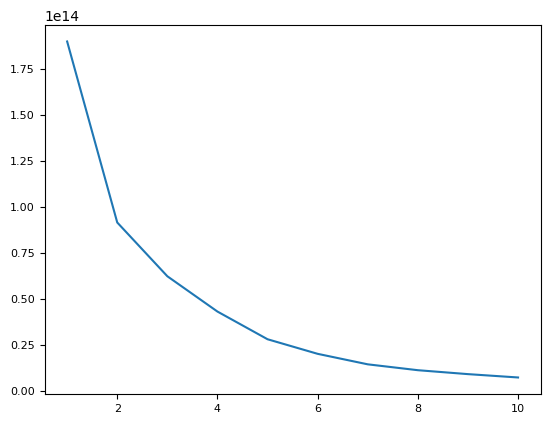

In [15]:
plt.rcParams.update({'font.size': 10})

inertia = []
for i in range(10):
    kmean = KMeans(n_clusters = i + 1, random_state = 0, n_init = 10)
    kmean.fit(Y_train.to_numpy().reshape(-1, 1))
    inertia.append(kmean.inertia_)
plt.plot([i + 1 for i in range(10)], inertia)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

In [16]:
kmean = KMeans(n_clusters = 2, random_state = 0, n_init = 10)
kmean.fit(Y_train.to_numpy().reshape(-1, 1))
X_label = kmean.predict(Y_train.to_numpy().reshape(-1, 1))
print(f"numbers of 1: {np.sum(X_label)}, numbers of 0: {X_label.shape[0] - np.sum(X_label)}")

numbers of 1: 6795, numbers of 0: 23201


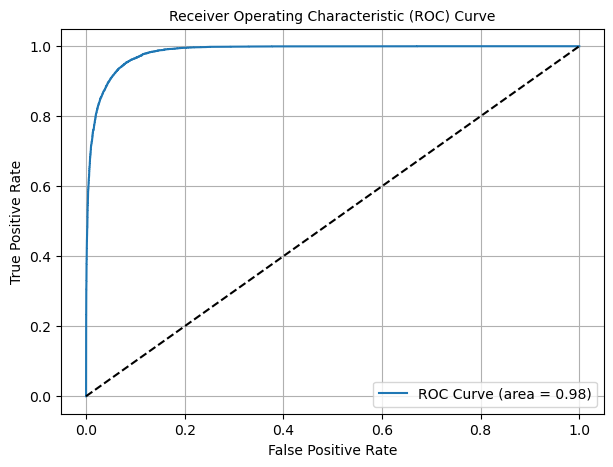

Precision: 0.8519, Recall: 0.8985, F1 score: 0.8746, Accuracy: 0.9416


In [17]:
classifier = lgb.LGBMClassifier(
                           boosting_type = 'gbdt', num_leaves = 10, 
                           max_depth = 6, learning_rate = 0.01, n_estimators = 4000, 
                           lambda_l1 = 3, lambda_l2 = 1, min_gain_to_split = 0.01,
                           bagging_freq = 10, scale_pos_weight = 1.5, feature_fraction = 0.6, verbose = -1
                          )
classifier.fit(X_train_standardize, X_label)
X_label_hat = classifier.predict(X_train_standardize) 
X_test_label_hat = classifier.predict(X_test_standardize) 
X_label_hat_prob = classifier.predict_proba(X_train_standardize)[:, 1]
classifier_performance(X_label, X_label_hat, X_label_hat_prob)

In [18]:
"""
eigens = np.linalg.eigvals(np.dot(X_train_standardize.T, X_train_standardize))
eigens.cumsum() / eigens.sum()
"""

'\neigens = np.linalg.eigvals(np.dot(X_train_standardize.T, X_train_standardize))\neigens.cumsum() / eigens.sum()\n'

In [19]:
"""
pca = PCA(n_components = 15)
pca.fit(X_train_standardize)
X_train_standardize = pca.transform(X_train_standardize)
X_test_standardize = pca.transform(X_test_standardize)

X_train_standardize = pd.DataFrame(X_train_standardize)
X_test_standardize = pd.DataFrame(X_test_standardize)
"""

'\npca = PCA(n_components = 15)\npca.fit(X_train_standardize)\nX_train_standardize = pca.transform(X_train_standardize)\nX_test_standardize = pca.transform(X_test_standardize)\n\nX_train_standardize = pd.DataFrame(X_train_standardize)\nX_test_standardize = pd.DataFrame(X_test_standardize)\n'

In [20]:
X_train_standardize = district_preprocessing(X_train_standardize, district_price_dict(X_train, Y_train))
X_test_standardize = district_preprocessing(X_test_standardize, district_price_dict(X_train, Y_train))

X_train_standardize = parkingtype_preprocessing(X_train_standardize, parkingtype_dict(X_train, Y_train))
X_test_standardize = parkingtype_preprocessing(X_test_standardize, parkingtype_dict(X_train, Y_train))

In [21]:
district = X_train_standardize.columns[X_train_standardize.columns.str.contains('District')]
X_train_standardize = X_train_standardize.drop(columns = district)
X_test_standardize = X_test_standardize.drop(columns = district)

parking = X_train_standardize.columns[X_train_standardize.columns.str.contains('Parking Type')]
X_train_standardize = X_train_standardize.drop(columns = parking)
X_test_standardize = X_test_standardize.drop(columns = parking)

In [22]:
lightgbm_model1 = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 10, max_depth = 5, learning_rate = 0.05, n_estimators = 4000, verbose = -1)
lightgbm_model0 = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 10, max_depth = 5, learning_rate = 0.05, n_estimators = 4000, verbose = -1)

train_1_index = np.where(X_label_hat == 1)[0]
train_0_index = np.where(X_label_hat == 0)[0]

test_1_index = np.where(X_test_label_hat == 1)[0]
test_0_index = np.where(X_test_label_hat == 0)[0]

lightgbm_model1.fit(X_train_standardize.iloc[train_1_index], Y_train.iloc[train_1_index])
lightgbm_model0.fit(X_train_standardize.iloc[train_0_index], Y_train.iloc[train_0_index])

Y_train_hat_gbm1 = lightgbm_model1.predict(X_train_standardize.iloc[train_1_index])
Y_train_hat_gbm0 = lightgbm_model0.predict(X_train_standardize.iloc[train_0_index])

train_index = np.concatenate([train_0_index, train_1_index], axis = 0)
Y_train_hat = np.concatenate([Y_train_hat_gbm0, Y_train_hat_gbm1], axis = 0)
train_dict = {'index' : train_index, 'predict': Y_train_hat}
train_pd = pd.DataFrame(train_dict)
train_pd = train_pd.sort_values(by = 'index')
train_pd.set_index('index', drop = True, inplace = True)
#display(train_pd)


Y_test_hat_gbm1 = lightgbm_model1.predict(X_test_standardize.iloc[test_1_index])
Y_test_hat_gbm0 = lightgbm_model0.predict(X_test_standardize.iloc[test_0_index])

test_index = np.concatenate([test_0_index, test_1_index], axis = 0)
Y_test_hat = np.concatenate([Y_test_hat_gbm0, Y_test_hat_gbm1], axis = 0)
test_dict = {'Index' : test_index, 'Price': Y_test_hat}
test_pd = pd.DataFrame(test_dict)
test_pd = test_pd.sort_values(by = 'Index')
#display(test_pd)
date = time.ctime(time.time())[:10].replace(' ', '')
test_pd.to_csv(f"test_2stageGBM_{date}.csv", index = False)

MAE_gbm = mean_absolute_error(Y_train, train_pd['predict'])
print(f"Light GBM Regression: {round(MAE_gbm, 3)}")

# 2024/03/24 parking type沒有 target encoded最佳

Light GBM Regression: 9925.909


In [23]:
print(Y_train_hat_gbm0.mean(), Y_train_hat_gbm1.mean())
print(Y_train_hat_gbm0.shape[0], Y_train_hat_gbm1.shape[0])

print(f"Group 0 MAE: {mean_absolute_error(Y_train_hat_gbm0, Y_train.iloc[train_0_index])}")
print(f"Group 1 MAE: {mean_absolute_error(Y_train_hat_gbm1, Y_train.iloc[train_1_index])}")

print("=========================================")
print(Y_test_hat_gbm0.mean(), Y_test_hat_gbm1.mean())
print(Y_test_hat_gbm0.shape[0], Y_test_hat_gbm1.shape[0])

109254.20858520578 235402.36477773075
22830 7166
Group 0 MAE: 8523.742861248322
Group 1 MAE: 14393.038959290441
110265.8553128797 235141.0754683068
13625 4375


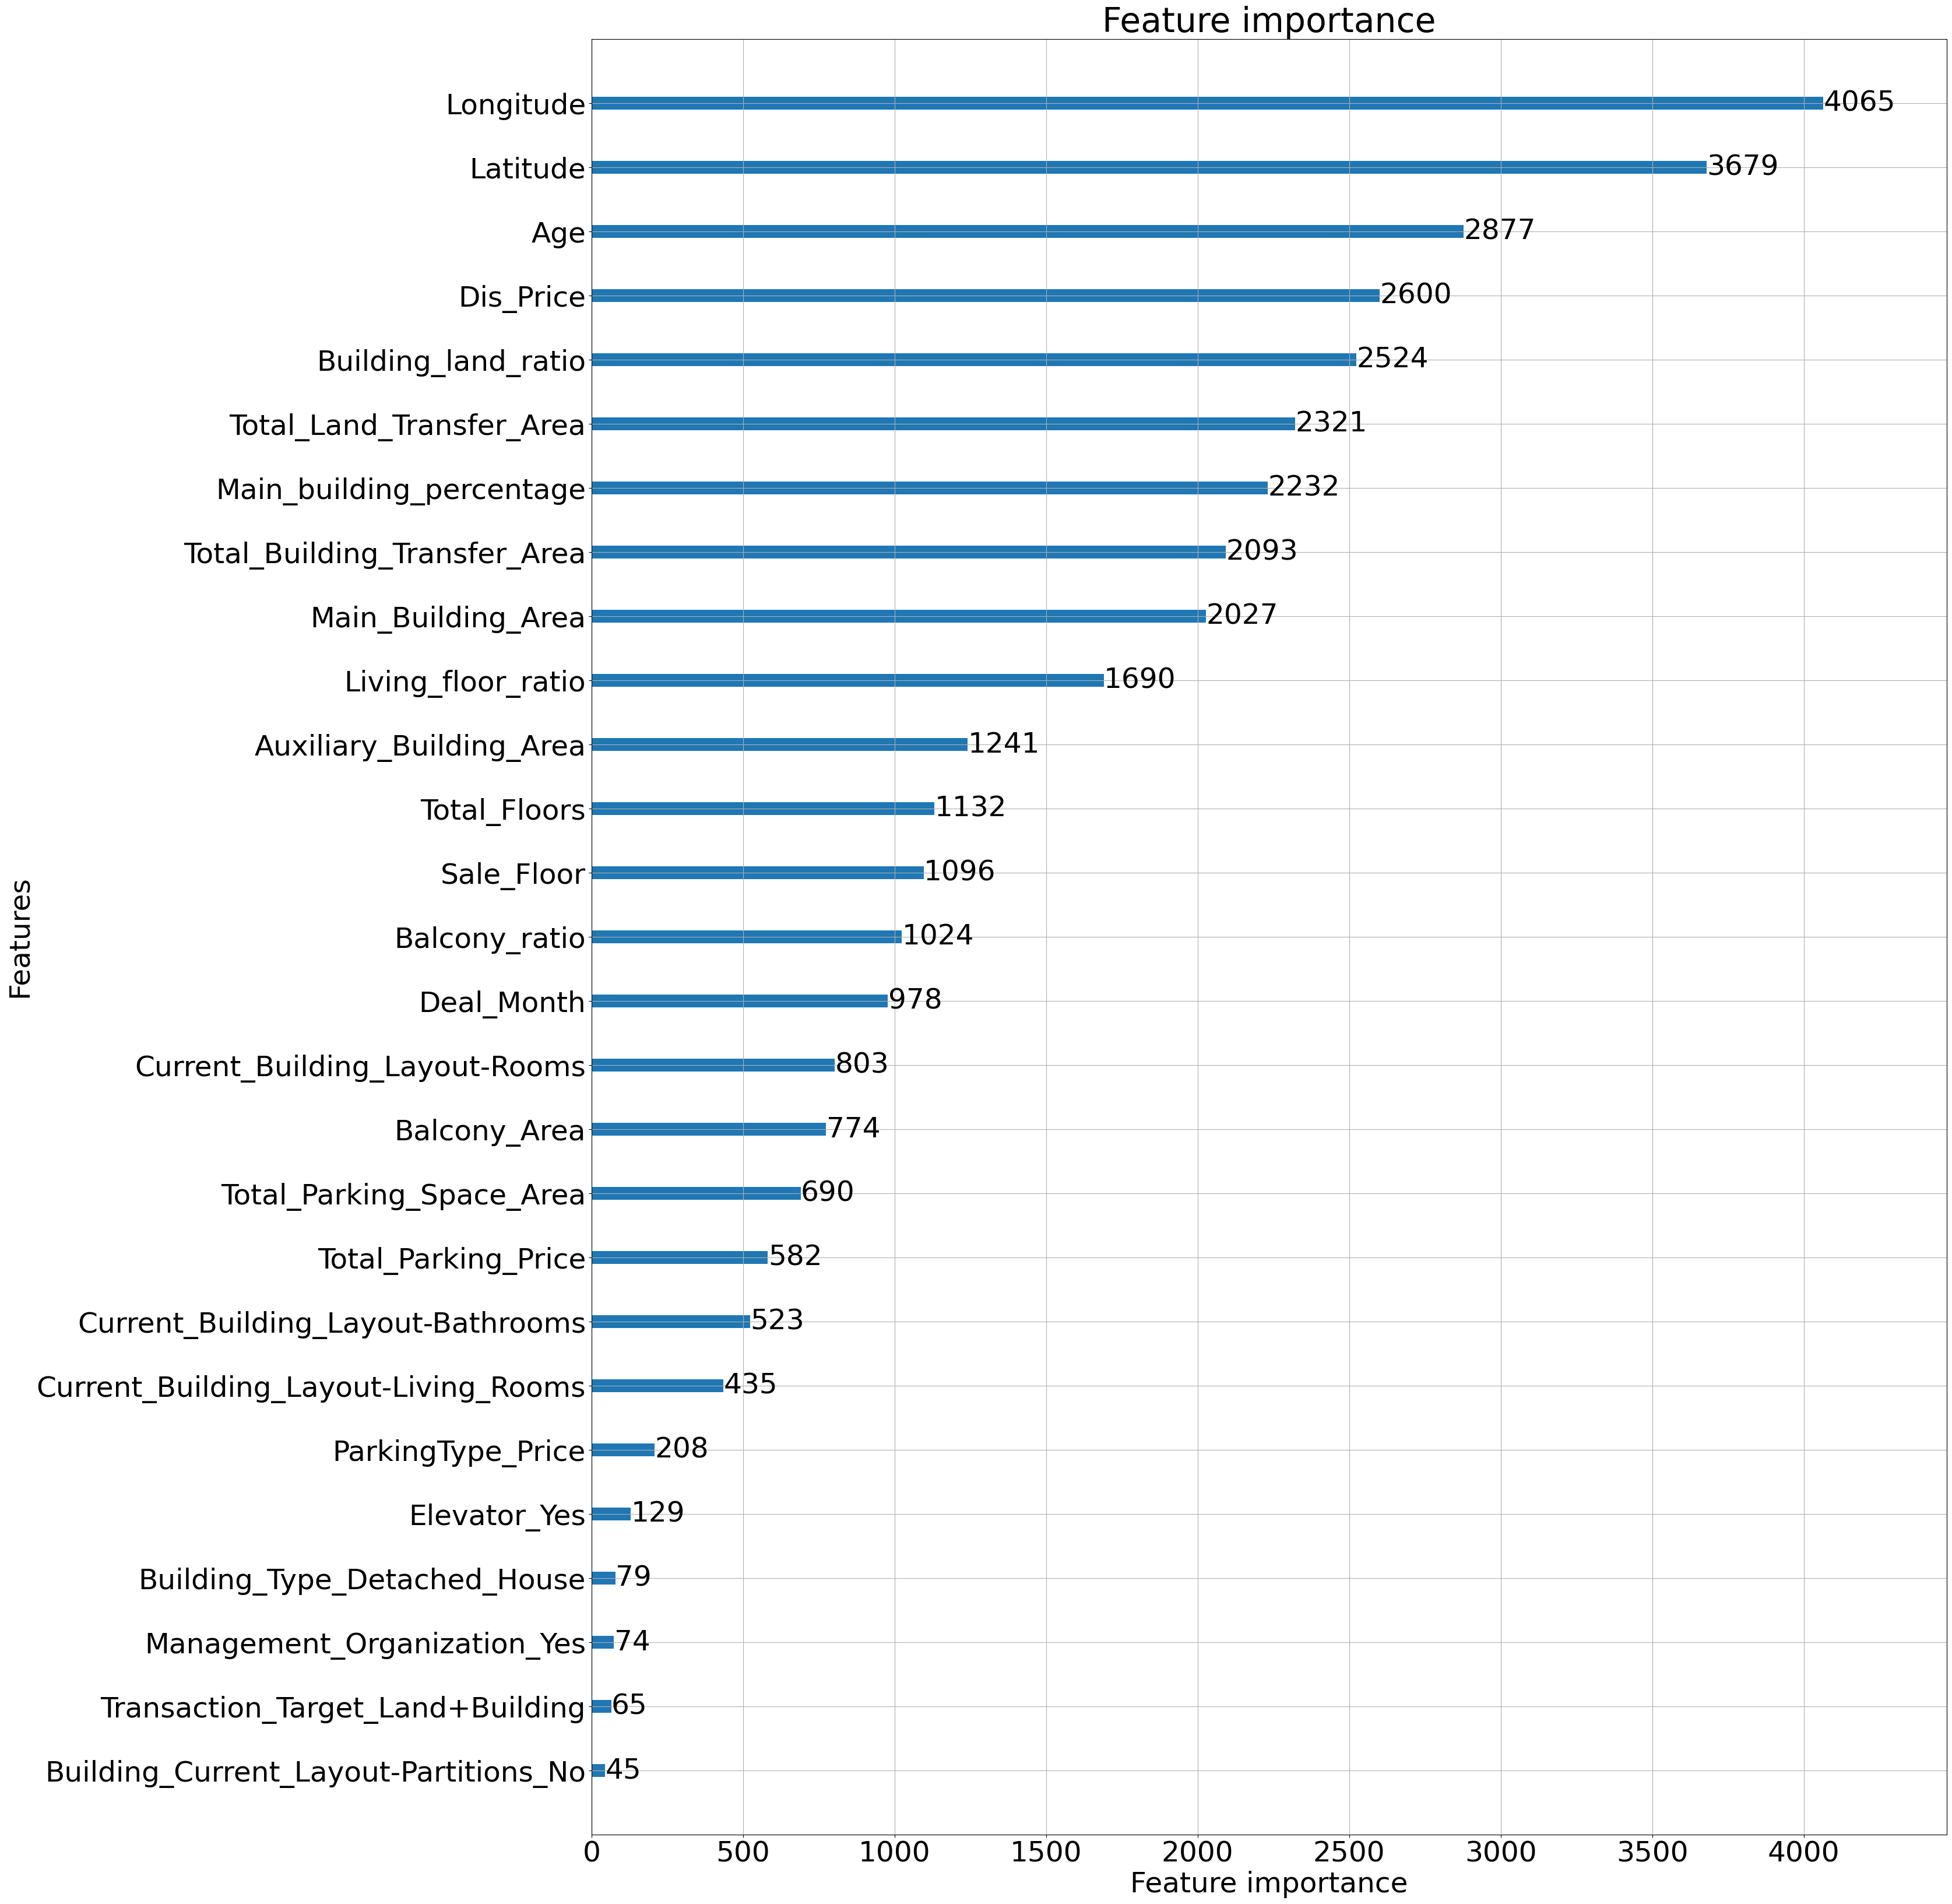

In [24]:
plt.rcParams.update({'font.size': 35})
ax = lgb.plot_importance(lightgbm_model0)
fig = ax.figure
fig.set_size_inches(30, 40)

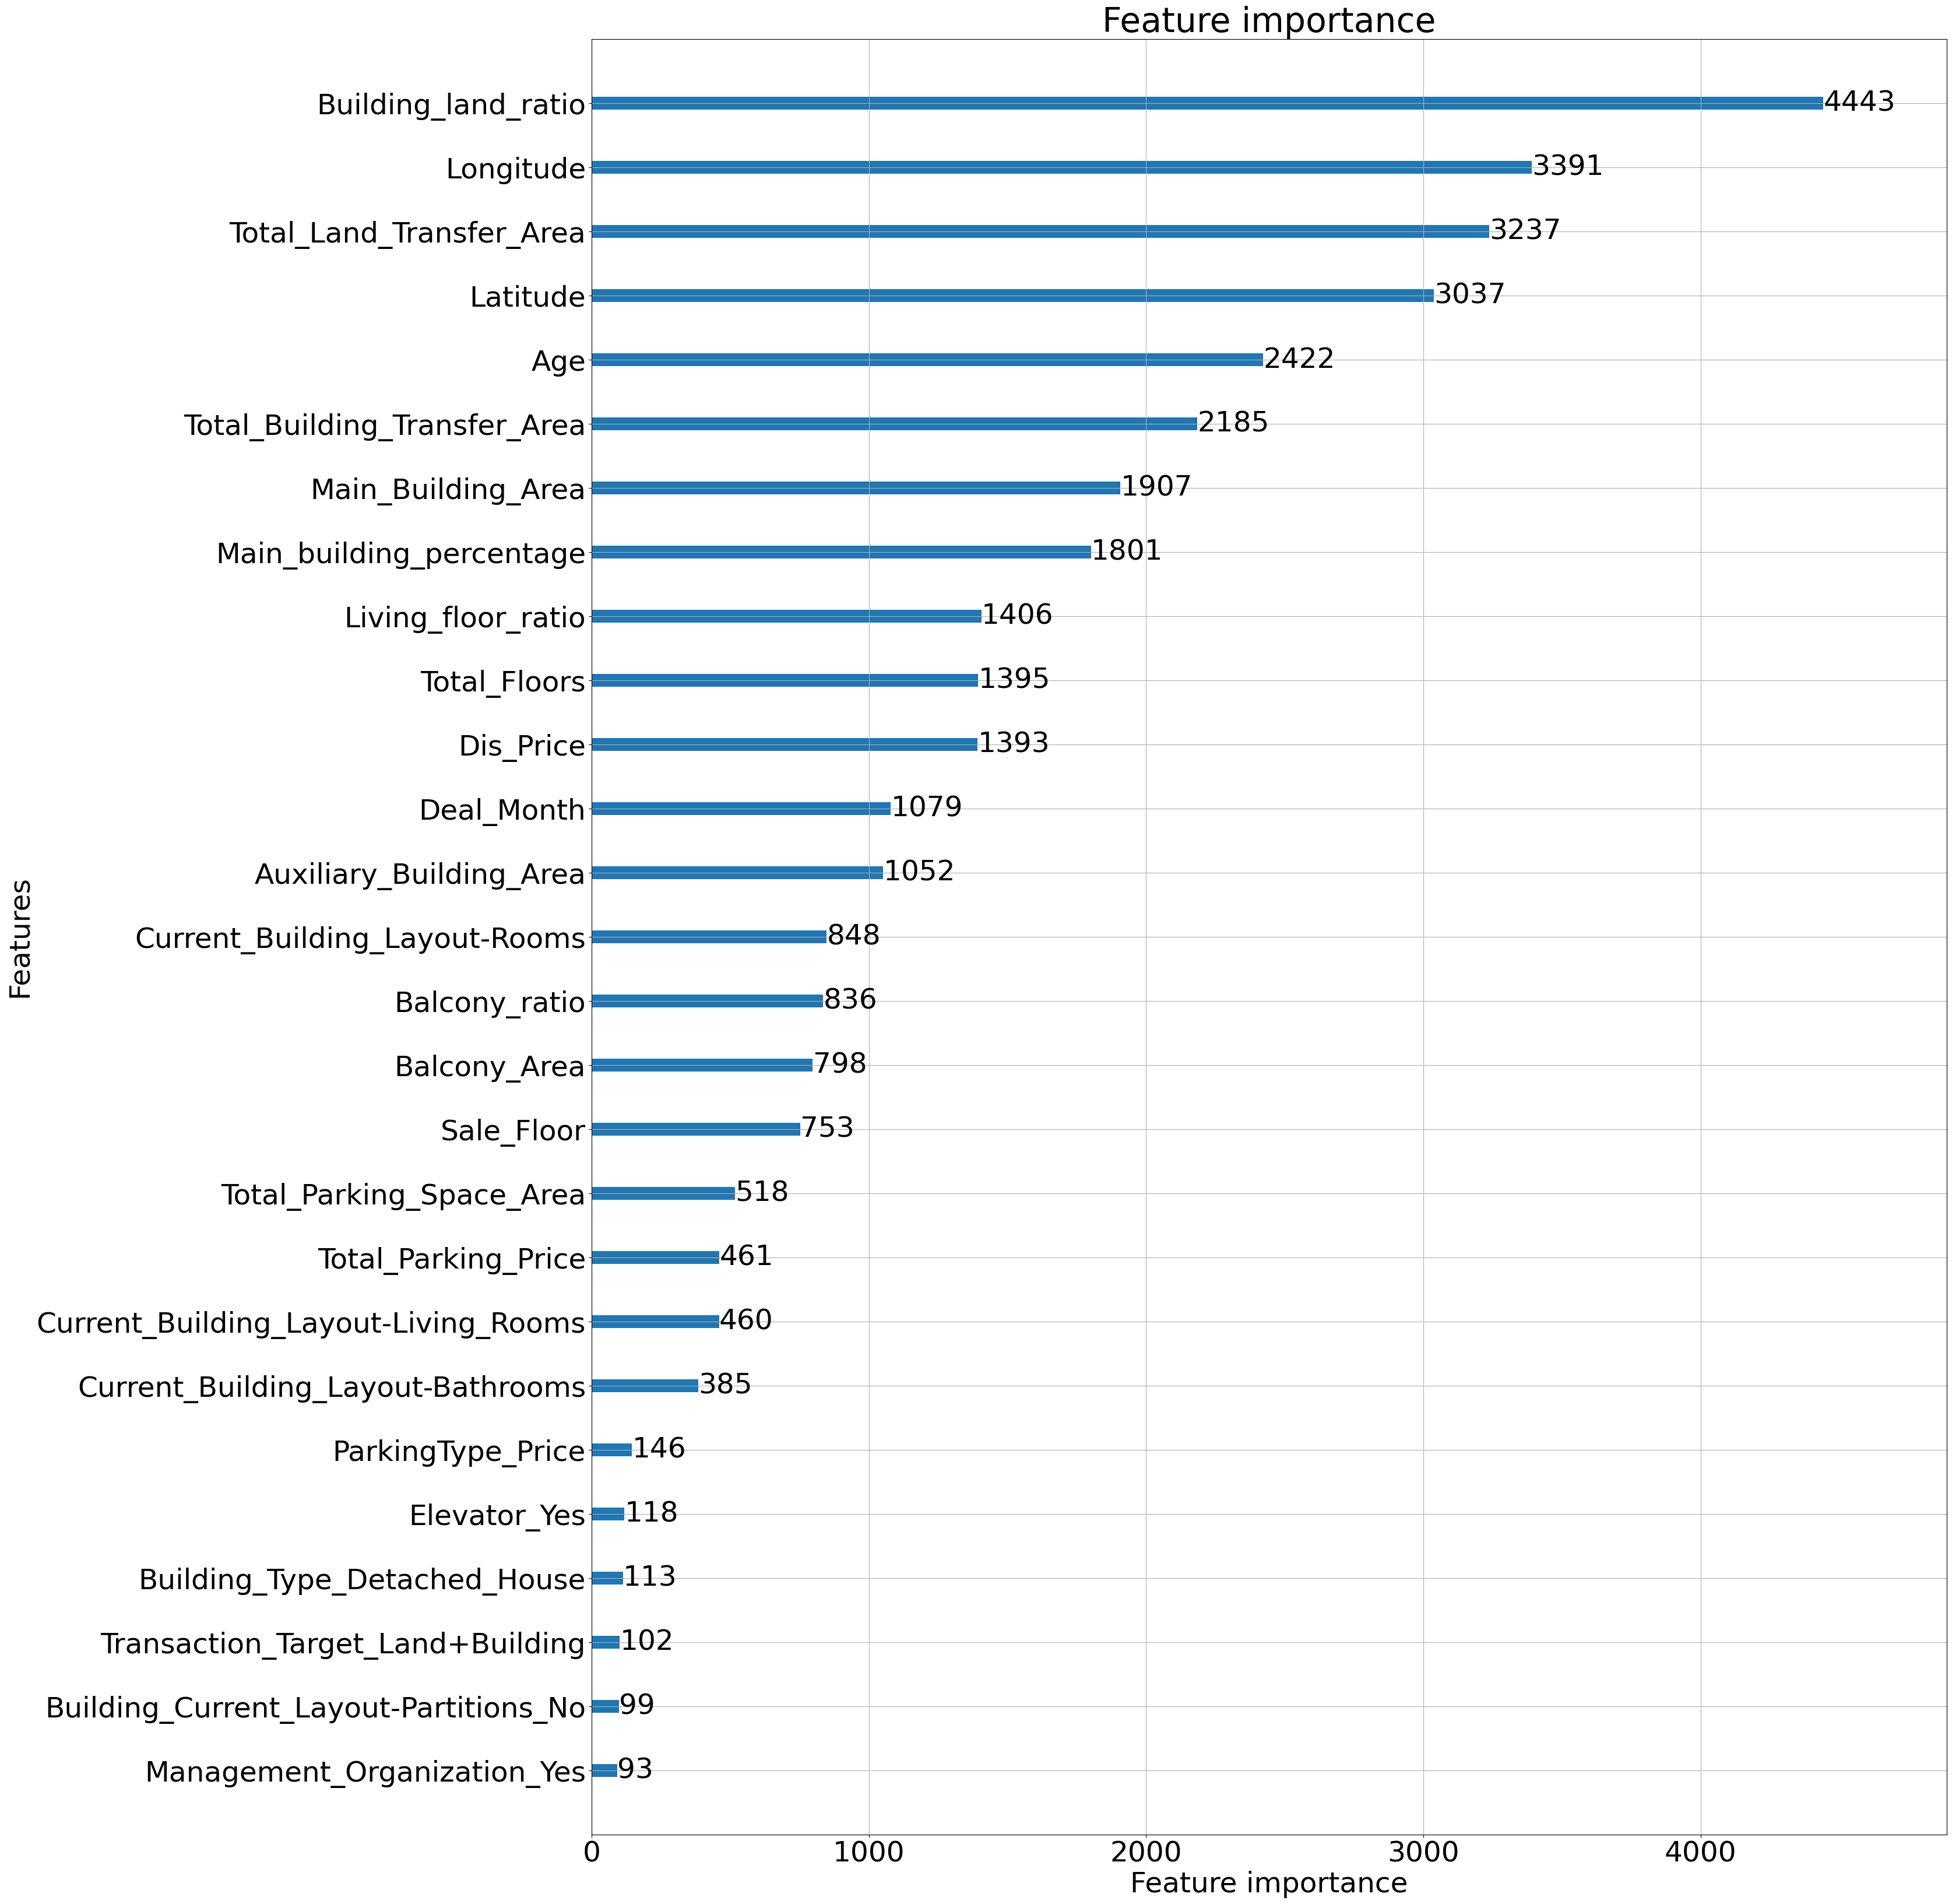

In [25]:
plt.rcParams.update({'font.size': 35})
ax = lgb.plot_importance(lightgbm_model1)
fig = ax.figure
fig.set_size_inches(30, 40)

In [26]:
district_col = [i for i in X_train.columns if 'District' in i]
training_error_data = {"District": [], "MAE": [], "Number": []}

for i in district_col:
    district_i_index = X_train[X_train[i] == 1][i].index
    Y_train_hat_district_i = train_pd['predict'].iloc[district_i_index]
    Y_train_district_i = Y_train.iloc[district_i_index]
    if Y_train_hat_district_i.shape[0]!= 0:
        MAE_gbm_i = mean_absolute_error(Y_train_district_i, Y_train_hat_district_i)
        #print(f"MAE for {i}: {round(MAE_gbm_i, 3)}")
        training_error_data['District'].append(i)
        training_error_data['MAE'].append(MAE_gbm_i)
        training_error_data['Number'].append(Y_train_hat_district_i.shape[0])
    else:
        print(f"----------No training data in {i}----------")
pd.DataFrame(training_error_data).sort_values(by = "MAE")

----------No training data in District_Shiding----------


,District,MAE,Number
36,District_Shuangxi,3546.528150,5
1,District_Sanzhi,4100.924879,147
9,District_Bali,4459.008959,356
32,District_Wanli,4829.033750,84
34,District_Gongliao,4836.605006,5
27,District_Tamsui,5455.089200,2322
6,District_Wugu,5482.636831,650
29,District_Ruifang,5608.491517,73
35,District_Jinshan,5729.142178,56
22,District_Linkou,5842.205180,1104


In [27]:
for i in X_train.columns:
    if 'District' in i:
        data = X_train.iloc[train_0_index][i]
        print(f"{i}: {data.sum()}")
        
        #if 'Shimen' in i:
            #print(data[data == 1])

District_Sanxia: 468
District_Sanzhi: 147
District_Sanchong: 1390
District_Zhonghe: 1941
District_Zhongshan: 285
District_Zhongzheng: 49
District_Wugu: 650
District_Xinyi: 104
District_Neihu: 606
District_Bali: 356
District_Beitou: 597
District_Nangang: 180
District_Tucheng: 1023
District_Pinglin: 1
District_Shilin: 437
District_Datong: 215
District_Da'an: 12
District_Wenshan: 769
District_Xindian: 1374
District_Xinzhuang: 2113
District_Songshan: 18
District_Banqiao: 1640
District_Linkou: 1096
District_Shulin: 580
District_Yonghe: 657
District_Xizhi: 1723
District_Taishan: 306
District_Tamsui: 2319
District_Shenkeng: 115
District_Ruifang: 72
District_Shiding: 0
District_Shimen: 3
District_Wanhua: 443
District_Wanli: 84
District_Luzhou: 555
District_Gongliao: 5
District_Jinshan: 55
District_Shuangxi: 5
District_Yingge: 437


In [28]:
for i in X_train.columns:
    if 'District' in i:
        data = X_train.iloc[train_1_index][i]
        print(f"{i}: {data.sum()}")
        #if 'Shimen' in i:
            #print(data[data == 1])

District_Sanxia: 5
District_Sanzhi: 0
District_Sanchong: 35
District_Zhonghe: 95
District_Zhongshan: 1255
District_Zhongzheng: 540
District_Wugu: 0
District_Xinyi: 710
District_Neihu: 705
District_Bali: 0
District_Beitou: 204
District_Nangang: 295
District_Tucheng: 6
District_Pinglin: 0
District_Shilin: 351
District_Datong: 216
District_Da'an: 1032
District_Wenshan: 210
District_Xindian: 203
District_Xinzhuang: 24
District_Songshan: 633
District_Banqiao: 256
District_Linkou: 8
District_Shulin: 12
District_Yonghe: 163
District_Xizhi: 6
District_Taishan: 0
District_Tamsui: 3
District_Shenkeng: 2
District_Ruifang: 1
District_Shiding: 0
District_Shimen: 1
District_Wanhua: 194
District_Wanli: 0
District_Luzhou: 0
District_Gongliao: 0
District_Jinshan: 1
District_Shuangxi: 0
District_Yingge: 0


In [29]:
for i in X_test.columns:
    if 'District' in i:
        data = X_test.iloc[test_0_index][i]
        print(f"{i}: {data.sum()}")
        
        #if 'Shimen' in i:
            #print(data[data == 1])

District_Sanxia: 275
District_Sanzhi: 105
District_Sanchong: 818
District_Zhonghe: 1096
District_Zhongshan: 151
District_Zhongzheng: 28
District_Wugu: 399
District_Xinyi: 45
District_Neihu: 376
District_Bali: 196
District_Beitou: 380
District_Nangang: 119
District_Tucheng: 598
District_Pinglin: 0
District_Shilin: 275
District_Datong: 134
District_Da'an: 9
District_Wenshan: 462
District_Xindian: 760
District_Xinzhuang: 1266
District_Songshan: 8
District_Banqiao: 978
District_Linkou: 641
District_Shulin: 363
District_Yonghe: 395
District_Xizhi: 1026
District_Taishan: 205
District_Tamsui: 1452
District_Shenkeng: 74
District_Ruifang: 54
District_Shiding: 2
District_Shimen: 1
District_Wanhua: 260
District_Wanli: 44
District_Luzhou: 334
District_Gongliao: 6
District_Jinshan: 47
District_Shuangxi: 3
District_Yingge: 240


In [30]:
for i in X_test.columns:
    if 'District' in i:
        data = X_test.iloc[test_1_index][i]
        print(f"{i}: {data.sum()}")
        
        #if 'Shimen' in i:
            #print(data[data == 1])

District_Sanxia: 0
District_Sanzhi: 0
District_Sanchong: 21
District_Zhonghe: 60
District_Zhongshan: 778
District_Zhongzheng: 311
District_Wugu: 3
District_Xinyi: 458
District_Neihu: 439
District_Bali: 0
District_Beitou: 113
District_Nangang: 163
District_Tucheng: 10
District_Pinglin: 0
District_Shilin: 231
District_Datong: 150
District_Da'an: 587
District_Wenshan: 135
District_Xindian: 102
District_Xinzhuang: 9
District_Songshan: 391
District_Banqiao: 160
District_Linkou: 1
District_Shulin: 6
District_Yonghe: 119
District_Xizhi: 3
District_Taishan: 0
District_Tamsui: 3
District_Shenkeng: 1
District_Ruifang: 0
District_Shiding: 0
District_Shimen: 0
District_Wanhua: 115
District_Wanli: 0
District_Luzhou: 3
District_Gongliao: 0
District_Jinshan: 2
District_Shuangxi: 0
District_Yingge: 1


## Taipei and New Taipei clusters

In [31]:
lightgbm_model_taipei = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 10, max_depth = 5, learning_rate = 0.05, n_estimators = 4000, verbose = -1)
lightgbm_model_newtaipei = lgb.LGBMRegressor(boosting_type = 'gbdt', num_leaves = 10, max_depth = 5, learning_rate = 0.05, n_estimators = 4000, verbose = -1)

lightgbm_model_taipei.fit(X_train_standardize.iloc[train_taipei_index], Y_train.iloc[train_taipei_index])
lightgbm_model_newtaipei.fit(X_train_standardize.iloc[train_newtaipei_index], Y_train.iloc[train_newtaipei_index])

Y_train_hat_gbm_taipei = lightgbm_model_taipei.predict(X_train_standardize.iloc[train_taipei_index])
Y_train_hat_gbm_newtaipei = lightgbm_model_newtaipei.predict(X_train_standardize.iloc[train_newtaipei_index])

train_index = np.concatenate([train_newtaipei_index, train_taipei_index], axis = 0)
Y_train_hat = np.concatenate([Y_train_hat_gbm_newtaipei, Y_train_hat_gbm_taipei], axis = 0)
train_dict = {'index' : train_index, 'predict': Y_train_hat}
train_pd_knowledge = pd.DataFrame(train_dict)
train_pd_knowledge = train_pd_knowledge.sort_values(by = 'index')
train_pd_knowledge.set_index('index', drop = True, inplace = True)
#display(train_pd)


Y_test_hat_gbm_taipei = lightgbm_model_taipei.predict(X_test_standardize.iloc[test_taipei_index])
Y_test_hat_gbm_newtaipei = lightgbm_model_newtaipei.predict(X_test_standardize.iloc[test_newtaipei_index])

test_index = np.concatenate([test_newtaipei_index, test_taipei_index], axis = 0)
Y_test_hat = np.concatenate([Y_test_hat_gbm_newtaipei, Y_test_hat_gbm_taipei], axis = 0)
test_dict = {'Index' : test_index, 'Price': Y_test_hat}
test_pd = pd.DataFrame(test_dict)
test_pd = test_pd.sort_values(by = 'Index')
#display(test_pd)
date = time.ctime(time.time())[:10].replace(' ', '')
test_pd.to_csv(f"test_Knowledge2StageGBM_{date}.csv", index = False)

MAE_gbm = mean_absolute_error(Y_train, train_pd_knowledge['predict'])
print(f"Light GBM Regression: {round(MAE_gbm, 3)}")

# 2024/03/24 parking type沒有 target encoded最佳

Light GBM Regression: 10032.422


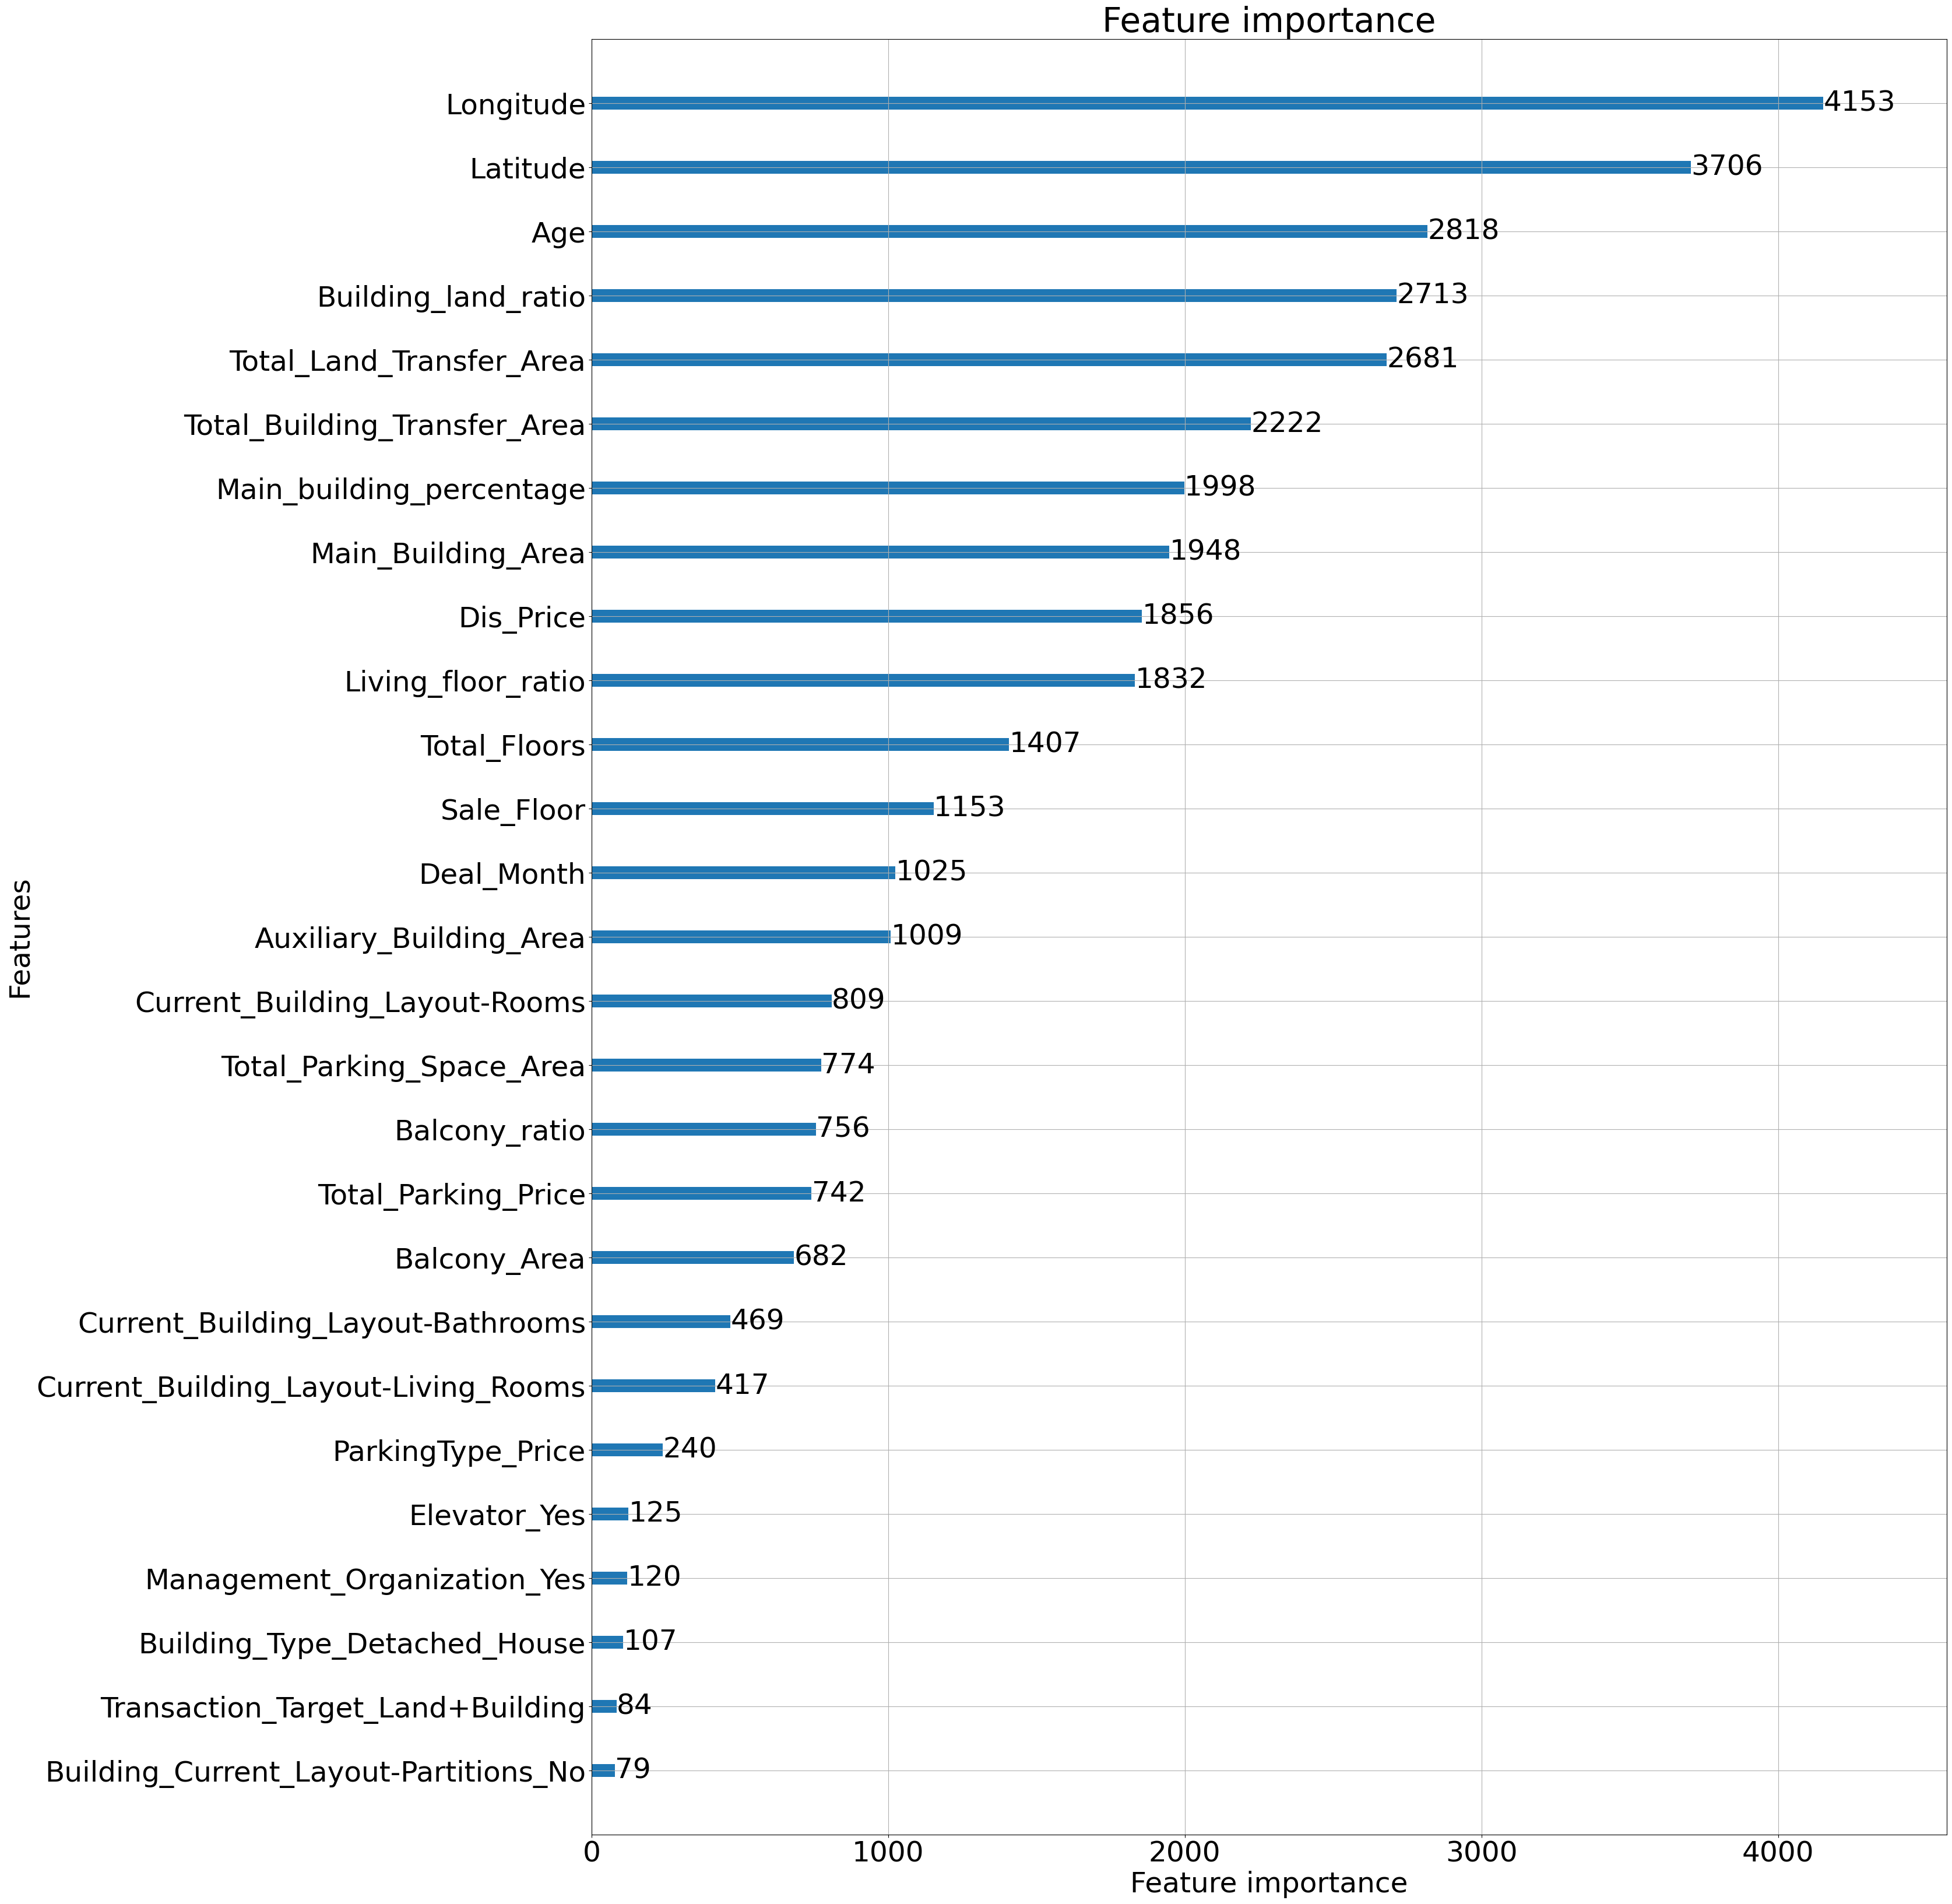

In [32]:
plt.rcParams.update({'font.size': 35})
ax = lgb.plot_importance(lightgbm_model_newtaipei)
fig = ax.figure
fig.set_size_inches(30, 40)

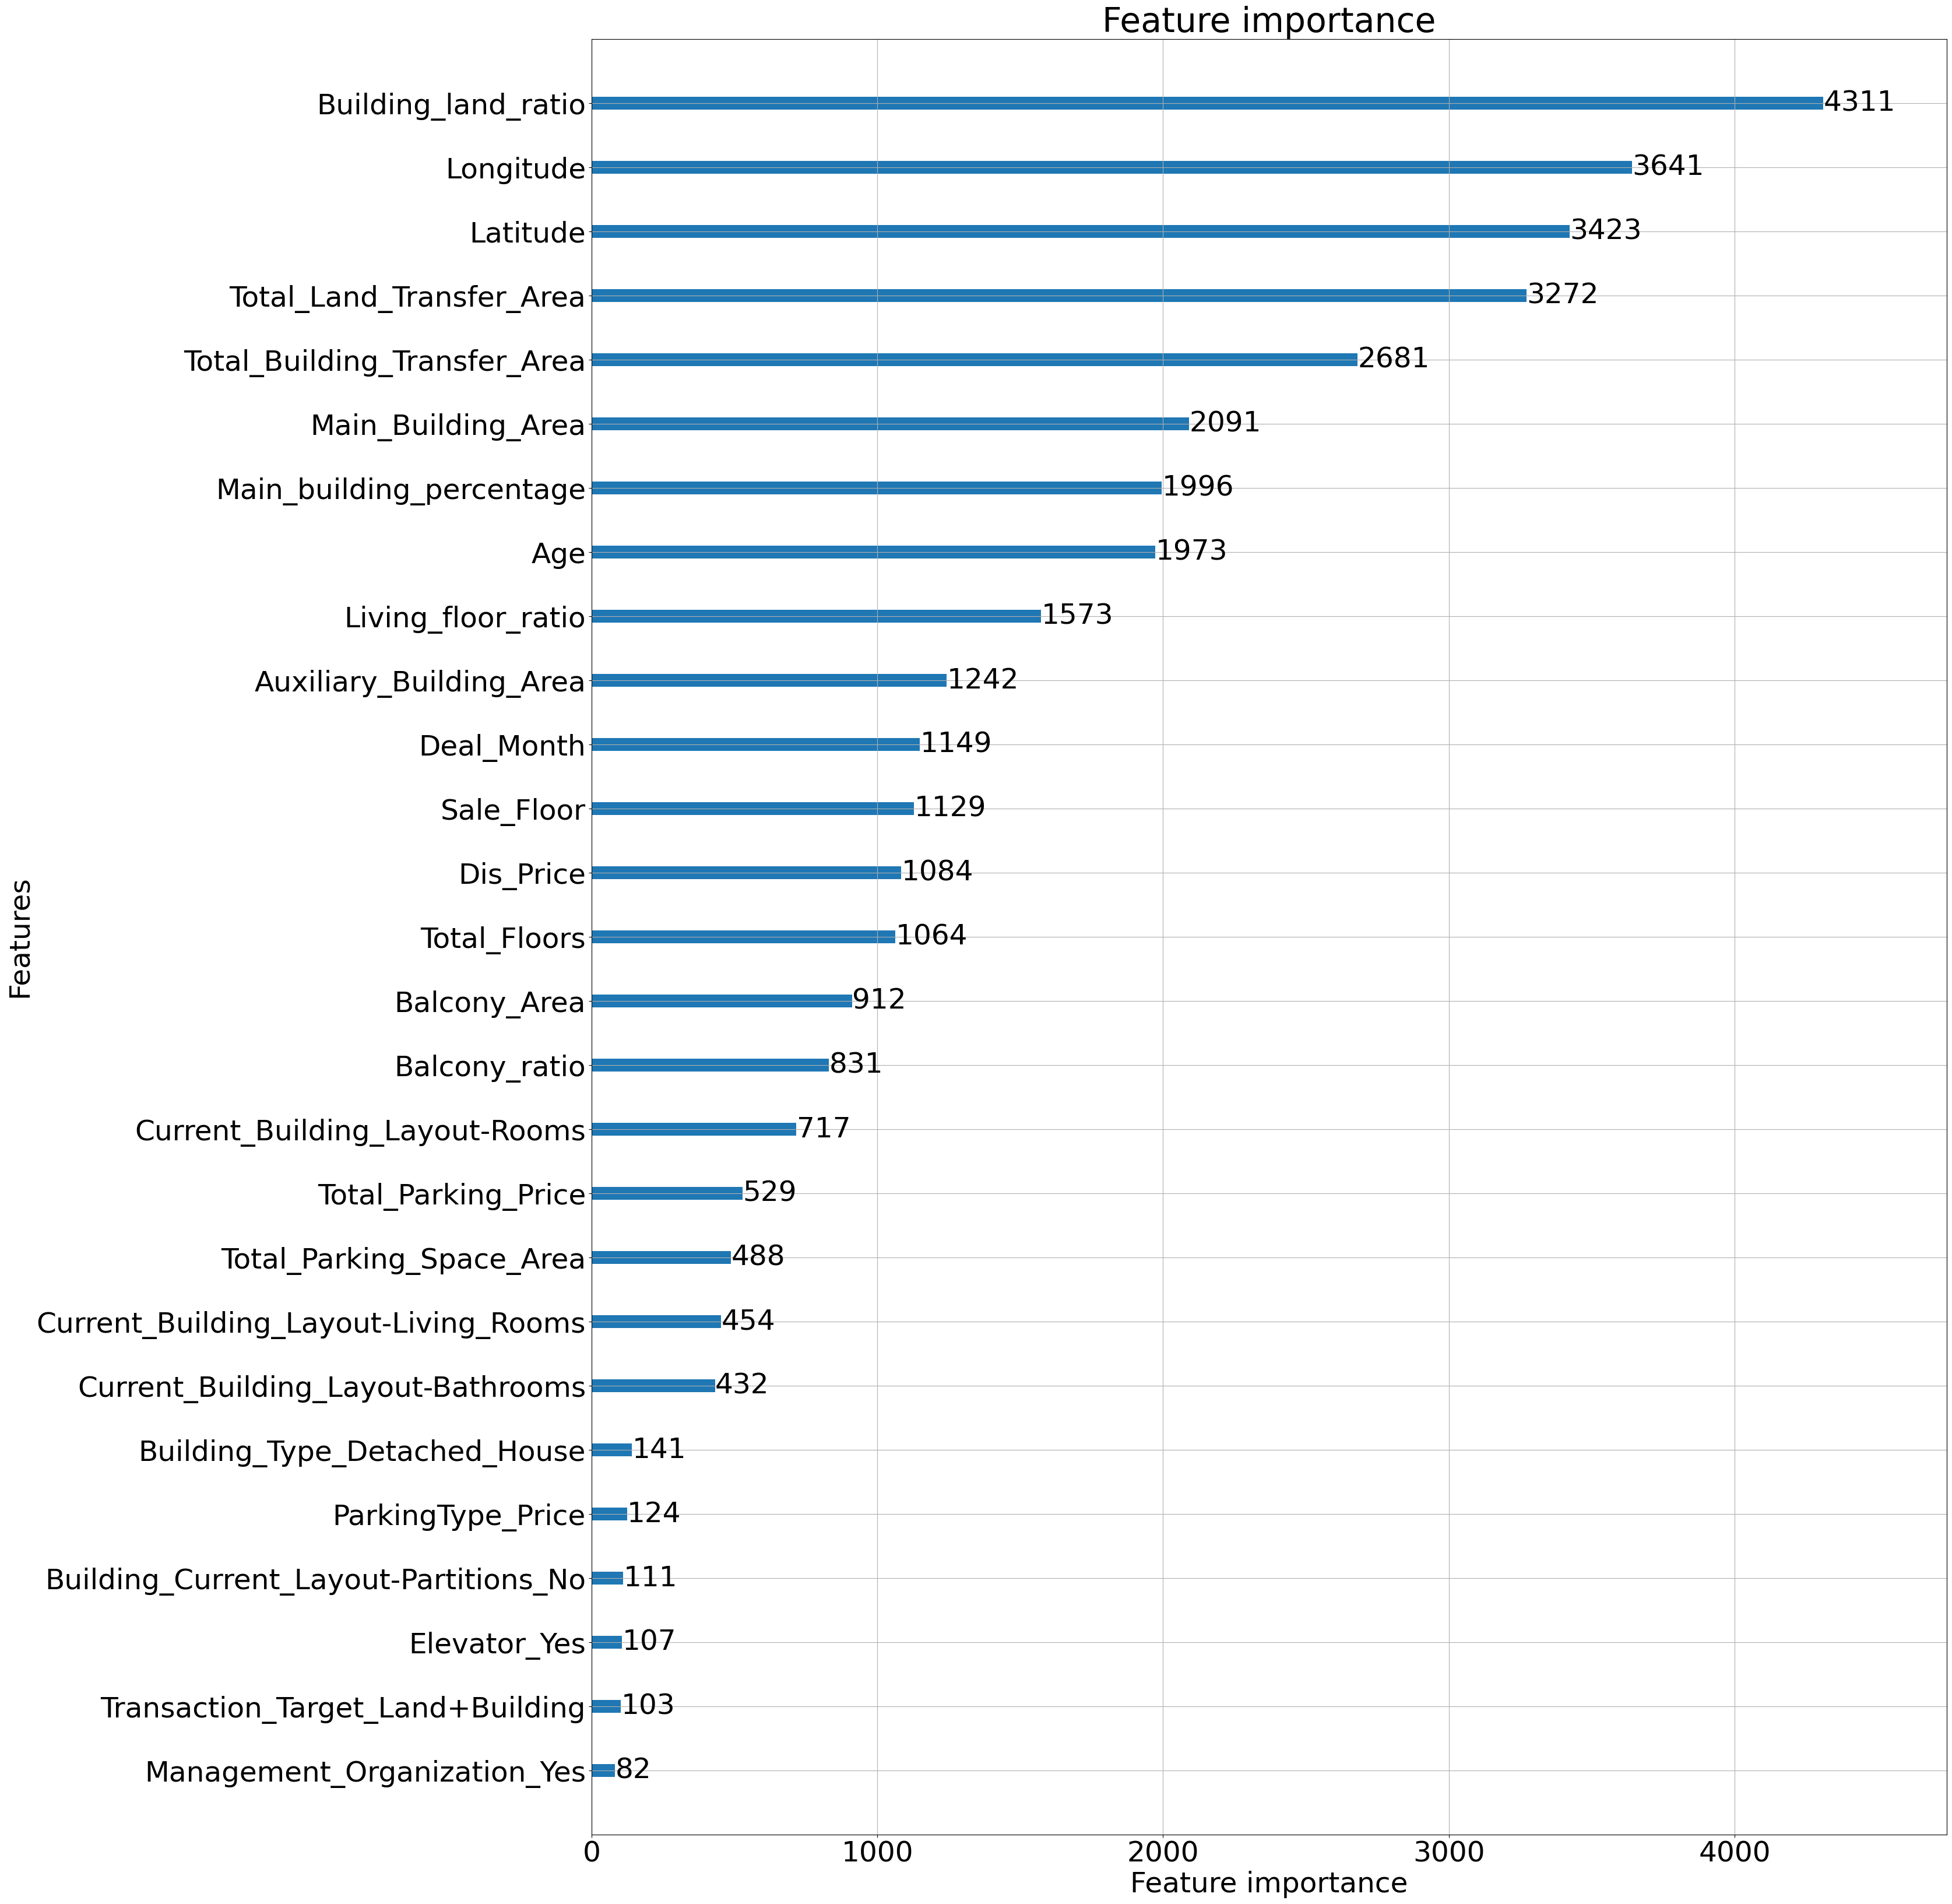

In [33]:
plt.rcParams.update({'font.size': 35})
ax = lgb.plot_importance(lightgbm_model_taipei)
fig = ax.figure
fig.set_size_inches(30, 40)

In [34]:
district_col = [i for i in X_train.columns if 'District' in i]
training_error_data = {"District": [], "MAE": [], "Number": []}

for i in district_col:
    district_i_index = X_train[X_train[i] == 1][i].index
    Y_train_hat_district_i = train_pd_knowledge['predict'].iloc[district_i_index]
    Y_train_district_i = Y_train.iloc[district_i_index]
    if Y_train_hat_district_i.shape[0]!= 0:
        MAE_gbm_i = mean_absolute_error(Y_train_district_i, Y_train_hat_district_i)
        #print(f"MAE for {i}: {round(MAE_gbm_i, 3)}")
        training_error_data['District'].append(i)
        training_error_data['MAE'].append(MAE_gbm_i)
        training_error_data['Number'].append(Y_train_hat_district_i.shape[0])
    else:
        print(f"----------No training data in {i}----------")
pd.DataFrame(training_error_data).sort_values(by = "MAE")

----------No training data in District_Shiding----------


,District,MAE,Number
30,District_Shimen,3534.013689,4
36,District_Shuangxi,3696.317375,5
1,District_Sanzhi,3894.057076,147
32,District_Wanli,4224.748624,84
9,District_Bali,4309.371921,356
27,District_Tamsui,5097.205017,2322
6,District_Wugu,5302.077460,650
22,District_Linkou,5447.812619,1104
37,District_Yingge,5557.744746,437
35,District_Jinshan,5717.826967,56


In [35]:
MAE_gbm = mean_absolute_error(Y_train, (train_pd['predict'] + train_pd_knowledge['predict'])/ 2)
print(f"Light GBM Regression: {round(MAE_gbm, 3)}")

Light GBM Regression: 9644.175


In [36]:
test_pd = pd.read_csv("test_2stageGBM_SunMar24.csv")
test_pd_knowledge = pd.read_csv("test_Knowledge2StageGBM_SunMar24.csv")
test_pd['Price'] = 0.5*(test_pd['Price'] + test_pd_knowledge['Price'])
test_pd.to_csv(f"test_Mix2StageGBM_{date}.csv", index = False)

In [37]:
X_train[X_train['District_Da\'an'] == 1]

,Total Land Transfer Area,Total Building Transfer Area,Current Building Layout-Rooms,Current Building Layout-Living Rooms,Current Building Layout-Bathrooms,Total Parking Space Area,Total Parking Price,Main Building Area,Auxiliary Building Area,Balcony Area,Latitude,Longitude,Deal Month,Total Floors,Sale Floor,District_Sanxia,District_Sanzhi,District_Sanchong,District_Zhonghe,District_Zhongshan,District_Zhongzheng,District_Wugu,District_Xinyi,District_Neihu,District_Bali,District_Beitou,District_Nangang,District_Tucheng,District_Pinglin,District_Shilin,District_Datong,District_Da'an,District_Wenshan,District_Xindian,District_Xinzhuang,District_Songshan,District_Banqiao,District_Linkou,District_Shulin,District_Yonghe,District_Xizhi,District_Taishan,District_Tamsui,District_Shenkeng,District_Ruifang,District_Shiding,District_Shimen,District_Wanhua,District_Wanli,District_Luzhou,District_Gongliao,District_Jinshan,District_Shuangxi,District_Yingge,Transaction Target Land+Building,Building Type Other,Building Type Storefront,Building Type Factory/Office,Building Type Farmhouse,Building Type Detached House,Building Current Layout-Partitions No,Management Organization Yes,Parking Type Flat on Ground Level,Parking Type Other,Parking Type Lift Plane,Parking Type Lift Mechanical,Parking Type Ramp Plane,Parking Type Ramp Mechanical,Parking Type Tower,Elevator Yes,Main building percentage,Building land ratio,Living floor ratio,Balcony ratio,Age
25,34.71,176.61,4,2,4,0.0,0,149.27,0.00,27.34,25.029733,121.543039,5,4,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.845196,5.088159,1.000000,0.154804,58
75,57.00,163.66,9,1,2,0.0,0,141.17,0.00,22.49,25.019084,121.533097,10,4,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.862581,2.871228,1.000000,0.137419,50
84,36.50,113.94,4,2,2,0.0,0,113.94,0.00,0.00,25.024906,121.546319,5,4,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.000000,3.121644,0.500000,0.000000,22
109,5.71,47.81,1,1,1,0.0,0,45.06,0.00,0.00,25.037092,121.549529,4,15,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.942481,8.373030,0.400000,0.000000,48
155,46.00,182.26,3,2,3,0.0,0,182.26,0.00,0.00,25.027656,121.531585,9,6,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,3.962174,0.166667,0.000000,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29949,32.95,116.56,6,2,5,0.0,0,95.60,10.81,0.00,25.026419,121.523691,6,5,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.820178,3.537481,1.000000,0.000000,40
29953,21.57,80.16,3,2,1,0.0,0,68.11,12.05,0.00,25.032433,121.553527,8,5,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.849676,3.716273,1.000000,0.000000,22
29966,12.85,75.42,1,1,1,0.0,0,43.84,0.00,3.90,25.017345,121.559856,1,13,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.581278,5.869261,0.384615,0.051710,1
29981,24.74,118.61,3,2,2,0.0,0,93.19,0.00,5.61,25.023493,121.551277,1,7,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0.785684,4.794260,0.857143,0.047298,22
